In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import random
import cv2
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tawsifurrahman/tuberculosis-tb-chest-xray-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/tuberculosis-tb-chest-xray-dataset


In [3]:
no_tb_data = "/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal"
tb_data = "/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis"

In [4]:
X_yes = []
for image in tqdm(os.listdir(tb_data)):
    image_path = os.path.join(tb_data, image)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    X_yes.append(img)

100%|██████████| 700/700 [00:13<00:00, 51.61it/s]


In [5]:
x_yes = np.array(X_yes)

In [6]:
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                             horizontal_flip=True, fill_mode='nearest')

aug_images = []
for image in tqdm(x_yes):  
    image = np.expand_dims(image, axis=0)  
    i = 0
    for batch in datagen.flow(image, batch_size=1):
        aug_images.append(batch[0])  
        i += 1
        if i >= 5:  
            break

100%|██████████| 700/700 [00:32<00:00, 21.45it/s]


In [7]:
TB_yes = []
for image in tqdm(aug_images):
    TB_yes.append([image, 1])

100%|██████████| 3500/3500 [00:00<00:00, 1176758.64it/s]


In [8]:
X_no = []
for image in tqdm(os.listdir(no_tb_data)):
    image_path = os.path.join(no_tb_data, image)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    X_no.append(img)

100%|██████████| 3500/3500 [01:07<00:00, 52.15it/s]


In [9]:
TB_no = []
for image in tqdm(X_no):
    TB_no.append([image, 0])

100%|██████████| 3500/3500 [00:00<00:00, 1741200.81it/s]


In [10]:
data = TB_yes + TB_no

In [11]:
random.shuffle(data)

In [12]:
X = []
y = []
for i, j in tqdm(data):
    X.append(i)
    y.append(j)

100%|██████████| 7000/7000 [00:00<00:00, 1416652.74it/s]


In [13]:
x = np.array(X)
y = np.array(y)

In [14]:
x_train = x[:5500]
y_train = y[:5500]

In [15]:
x_test = x[5500:7000]
y_test = y[5500:7000]

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

model = Sequential()

# Reduced number of filters, added regularization
model.add(Conv2D(64, (3, 3), activation="relu", input_shape=(224, 224, 3), kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu", kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu", kernel_regularizer=l2(0.001)))
model.add(Conv2D(32, (3, 3), activation="relu", kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dense(64, activation="relu", kernel_regularizer=l2(0.001)))
# model.add(Dropout(0.4))
model.add(Dense(32, activation="relu", kernel_regularizer=l2(0.001)))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,280,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,348,609 (5.14 MB)

 Trainable params: 1,348,609 (5.14 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# history = model.fit(x_train, y_train, validation_split= .2, epochs = 10)
history = model.fit(
    x_train, y_train,
    validation_split=.2,
    epochs=50,batch_size=16
)

Epoch 1/50


I0000 00:00:1757424457.220417      69 service.cc:145] XLA service 0x7d20d800e380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757424457.220476      69 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757424457.220480      69 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  7/275 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.4874 - loss: 13.4249

I0000 00:00:1757424464.333167      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


275/275 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.7323 - loss: 2.0513 - val_accuracy: 0.9400 - val_loss: 0.3548
Epoch 2/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9159 - loss: 0.4765 - val_accuracy: 0.9636 - val_loss: 0.3103
Epoch 3/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9618 - loss: 0.3227 - val_accuracy: 0.9636 - val_loss: 0.2760
Epoch 4/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9514 - loss: 0.3371 - val_accuracy: 0.9609 - val_loss: 0.3344
Epoch 5/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9659 - loss: 0.2830 - val_accuracy: 0.9782 - val_loss: 0.2340
Epoch 6/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9854 - loss: 0.2374 - val_accuracy: 0.9791 - val_loss: 0.2216
Epoch 7/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9831 - loss: 0.1951 - val_accuracy: 0.9764 - val_loss: 0.2349
Epoch 8/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9795 - loss: 0.2062 - val_accuracy: 0.97

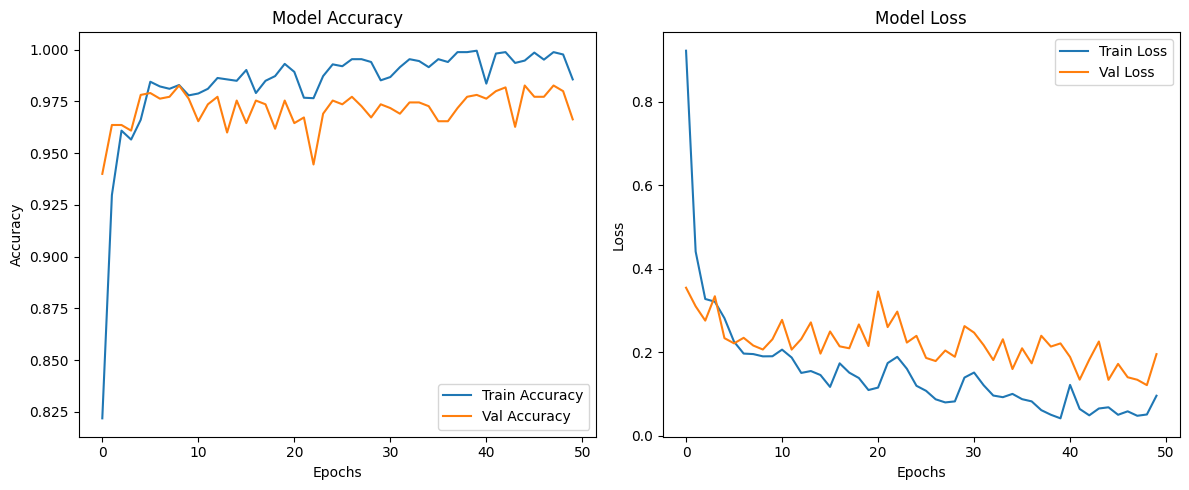

In [19]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
threshold = 0.5
y_pred = (model.predict(x_test)>= threshold).astype(int)

47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step


<Figure size 1200x1000 with 0 Axes>

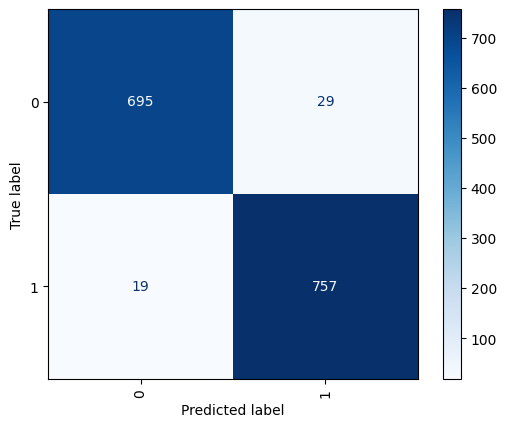

In [21]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()

In [22]:
model.evaluate(x_test, y_test)

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9687 - loss: 0.1792


[0.1861916482448578, 0.9679999947547913]